### Analyze results produced by run_wofost_phenology.py        

In [61]:
import geopandas as gpd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from pyproj import Transformer

get location of results

In [187]:
cwd = Path.cwd().absolute()
output_dir = cwd.parent.joinpath('results')
print(output_dir)

c:\Users\F80840370\projects\scClim\wofost\winter_wheat_phenology\results


read data and concatenate to one geopandas dataframe

In [9]:
data=[]
for year in range(1972,2022,1):
    data.append(gpd.read_file(output_dir.joinpath(f'results_ww_gs_{year-1}-{year}.gpkg')))

df_all=pd.concat(data,axis=0)

translate maturity and anthesis dates into DOY values

In [10]:
df_all['maturity_doy']=pd.to_datetime(df_all.maturity_date).dt.dayofyear
df_all['anthesis_doy']=pd.to_datetime(df_all.anthesis_date).dt.dayofyear


In [13]:
df_all.keys()

Index(['id', 'harvest_year', 'sowing_date', 'sowing_date_type', 'genotype',
       'emergence_date', 'anthesis_date', 'maturity_date', 'n_fields',
       'area_ha', 'geometry', 'maturity_doy', 'anthesis_doy'],
      dtype='object')

C:\Users\F80840370\AppData\Local\Temp\ipykernel_12704\4016935580.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df_all.groupby(['harvest_year']).boxplot(column=columns[i],subplots=False,rot=45,ax=ax,fontsize=fontsize)
C:\Users\F80840370\AppData\Local\Temp\ipykernel_12704\4016935580.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df_all.groupby(['harvest_year']).boxplot(column=columns[i],subplots=False,rot=45,ax=ax,fontsize=fontsize)


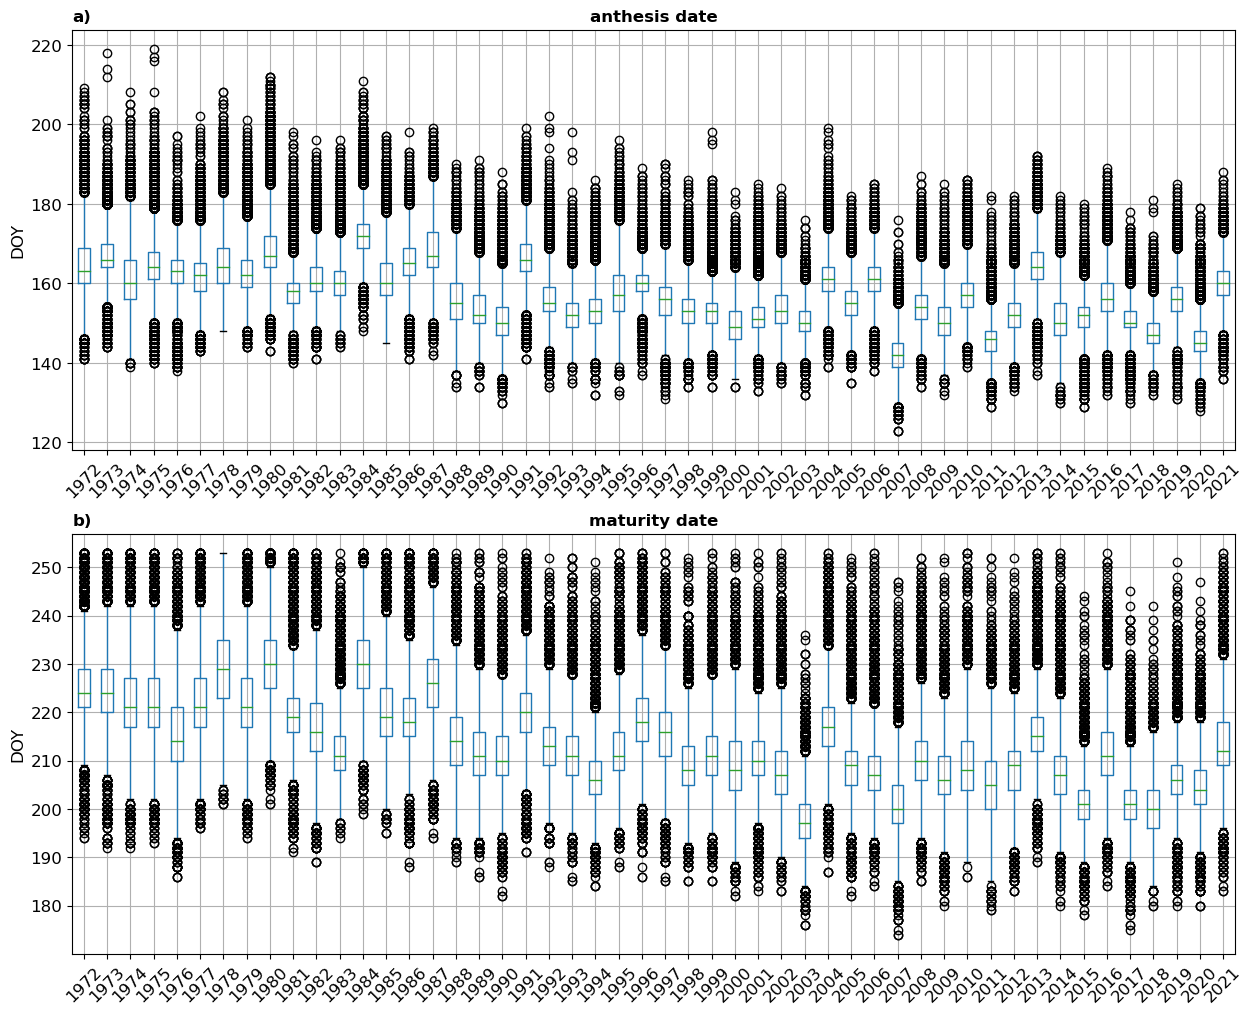

In [38]:
labels=['a)','b)']
names=['anthesis date','maturity date']
columns=['anthesis_doy','maturity_doy']
fontsize=12
matplotlib.rcParams.update({'font.size': fontsize})
fig,axs=plt.subplots(2,1,figsize=(15,12))

for i,ax in enumerate(axs):
    #set label
    ax.text(0,1.02,labels[i], transform=ax.transAxes,fontweight='bold')
    #set title of subplot
    ax.text(0.5,1.02,names[i], ha='center', transform=ax.transAxes,fontweight='bold')

    #plot data
    df_all.groupby(['harvest_year']).boxplot(column=columns[i],subplots=False,rot=45,ax=ax,fontsize=fontsize)

    #change xlabels
    ax.set_xticklabels(list(set(df_all.harvest_year.values)))
    ax.set_ylabel('DOY')



Now, lets verify the modeled maturity date with historical harvest data from MeteoSwiss. First read data and Metadata

In [119]:
####### Meteoswiss phenology data
datadir = cwd.parent.joinpath('verification_data/MeteoSwiss')
filedir=datadir.joinpath('wheat_harvest_data.txt')
metadata_dir = datadir.joinpath('wheat_harvest_legend_stations.csv')

#read metadata
metadata = pd.read_csv(metadata_dir,header=0,delimiter=',',encoding_errors='ignore')

#read and prepare phenology data
colnames = ['stn', 'time', 'mtria89d']
data_MCH = pd.read_csv(filedir, delimiter=';', header=0,
                       encoding="ISO-8859-1", names=colnames)
# remove colnames in data and missing values
data_MCH = data_MCH[~data_MCH.stn.str.contains('stn')]
data_MCH = data_MCH[~data_MCH.mtria89d.str.contains('-')]

# compute datetime and DOY
data_MCH.loc[:, 'datetime'] = pd.to_datetime(
    data_MCH['mtria89d'], format='%Y%m%d')
data_MCH.loc[:, 'harvest'] = data_MCH['datetime'].dt.dayofyear
# rename columns
data_MCH = data_MCH.rename(columns={"time": "year"})


Plot de MCH harvest data

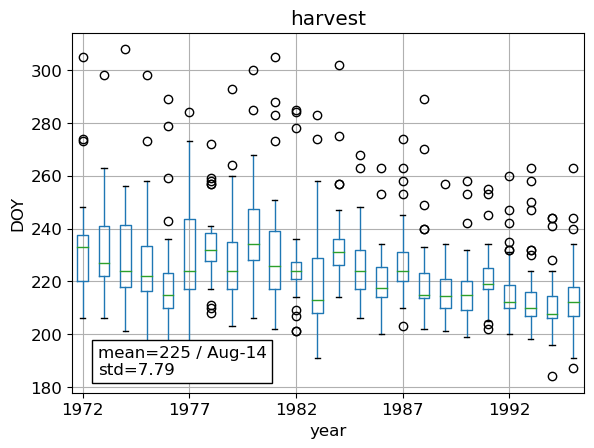

In [121]:

# plot it (per year)
# remove years before 1972
data_MCH = data_MCH[data_MCH.year>='1972']
fig, ax = plt.subplots()

data_MCH.boxplot(column='harvest', by='year', ax=ax)

#plot time mean and standard deviation
mean_harvest_date = data_MCH.groupby(by='year')['harvest'].mean().mean()
std_harvest_date = data_MCH.groupby(by='year')['harvest'].mean().std()
#ax.axhline(y=mean_heading_date, color='red')
lower = mean_harvest_date-std_harvest_date
upper = mean_harvest_date+std_harvest_date
#ax.fill_between(x=[0, 46], y1=[lower,lower], y2=[upper,upper],color='lightcoral',alpha=0.5)

#plot text box
date = pd.to_datetime(int(np.round(mean_harvest_date)), unit='D', origin='2021')
datestr = date.strftime('%b-%d')
ax.text(0.05, 0.05, 'mean='+str(int(np.round(mean_harvest_date))) +
        ' / '+datestr+'\n'+'std='+str(np.round(std_harvest_date,decimals=2)), bbox=dict(facecolor='w'), transform=ax.transAxes)

# format figure
ax.set_ylabel('DOY')
ax.set_xticks(ax.get_xticks()[0::5])
fig.suptitle('')

plt.show()

Prepare Metadata and use geopandas spatial join to link it to modeled harvest dates at the correct location

In [122]:
#get x/y coordinates
data={d: [] for d in ['X','Y','altitude','stn']}

stns=[]
for stn in metadata.stn.values:
    x=metadata.loc[metadata['stn']==stn]['X'].values[0]
    y=metadata.loc[metadata['stn']==stn]['Y'].values[0]
    alt=metadata.loc[metadata['stn']==stn]['altitude'].values[0]
    
    #change projection to standard Swiss LV95
    transformer = Transformer.from_crs("epsg:21781", "epsg:2056",always_xy=True)
    xx,yy=transformer.transform(x,y)
    data['X'].append(xx)
    data['Y'].append(yy)
    data['altitude'].append(alt)
    data['stn'].append(stn)

metadata_gdf=gpd.GeoDataFrame(data,geometry=gpd.points_from_xy(data['X'],data['Y'],crs="epsg:2056"))
joined=gpd.sjoin(metadata_gdf,df_all,how='left',op='within')

c:\Users\F80840370\Anaconda3\envs\climada_env_3.9\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Add column with modeled harvest to the MCH data

In [177]:
modeled_harvest=[]
for _,row in data_MCH.iterrows():
    modeled_doy=joined[(joined.stn==row.stn) & (joined.harvest_year==float(int(row.year)))]['maturity_doy']
    if len(modeled_doy.values)>0:
        modeled_harvest.append(modeled_doy.values[0])
    else:
        modeled_harvest.append(np.nan)

data_MCH['modeled_harvest']=modeled_harvest

Plot modeled vs. observed harvest date

Coefficient of Determination 0.5763101938089865


Text(0.8, 0.75, 'R$^2$=0.5763')

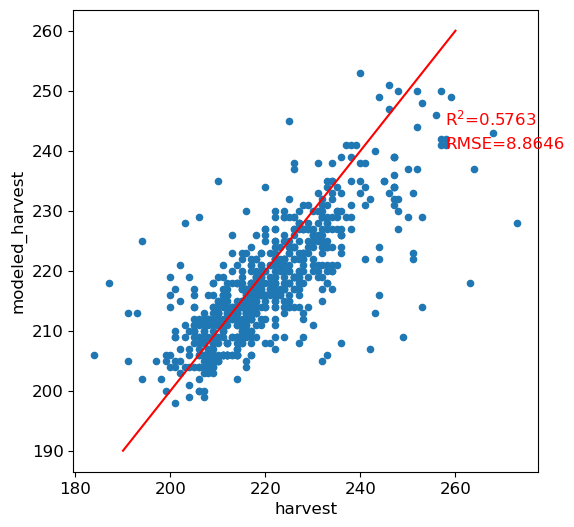

In [186]:
import scipy
def mse(x,y):
    return np.square(np.subtract(x,y)).mean() 

def get_stats_sim_vs_obs(DOY_sim,DOY_obs):
    
    import math 

    #compute metrics
    result=scipy.stats.linregress(DOY_sim,DOY_obs)
    R_square = result.rvalue*result.rvalue 
    print('Coefficient of Determination', R_square) 
    
    MSE = mse(DOY_obs, DOY_sim)
    RMSE = math.sqrt(MSE)
    
    return R_square,RMSE

data_MCH=data_MCH.dropna()

fig,ax=plt.subplots(figsize=(6,6))
data_MCH.plot.scatter(x='harvest',y='modeled_harvest',ax=ax)
R2,RMSE=get_stats_sim_vs_obs(data_MCH['harvest'],data_MCH['modeled_harvest'])


#print measures
ax.plot([190,260],[190,260],color='r')
ax.text(0.8,0.7,'RMSE={}'.format(np.round(RMSE,decimals=4)),transform=ax.transAxes,color='r')
ax.text(0.8,0.75,'R$^2$={}'.format(np.round(R2,decimals=4)),transform=ax.transAxes,color='r')


Plot locations of MCH data and model domain. 

<Axes: >

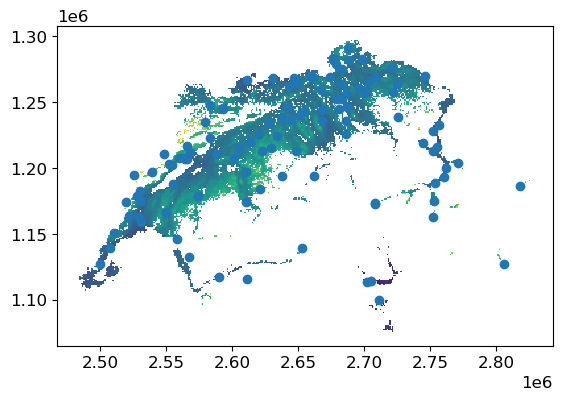

In [150]:
fig,ax=plt.subplots()
df_all[df_all.harvest_year==2021].plot('maturity_doy',ax=ax)
metadata_gdf.plot(ax=ax)